In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

## Exploring the data

In this workbood we'll have a look 

In [2]:
df = pd.read_parquet("./data/cleaned.parquet")

df

,datetime,usage,temp,stress,load,case_under,case_frame,case_cable,case_gpio,top_solid,top_holed,top_intake,top_exhaust,heatsink_main,heatsink_sub
0,2020-07-30 17:51:07,44.5,46.698,2,NaN,1,1,1,0,1,0,0,0,1,1
1,2020-07-30 17:51:08,49.9,47.236,2,NaN,1,1,1,0,1,0,0,0,1,1
2,2020-07-30 17:51:09,50.0,48.312,2,NaN,1,1,1,0,1,0,0,0,1,1
3,2020-07-30 17:51:10,50.0,48.312,2,NaN,1,1,1,0,1,0,0,0,1,1
4,2020-07-30 17:51:11,50.2,48.850,2,NaN,1,1,1,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61053,2020-07-30 08:54:52,25.0,78.440,1,NaN,1,1,1,1,1,0,0,0,1,1
61054,2020-07-30 08:54:53,25.1,78.440,1,NaN,1,1,1,1,1,0,0,0,1,1
61055,2020-07-30 08:54:54,25.4,77.902,1,NaN,1,1,1,1,1,0,0,0,1,1
61056,2020-07-30 08:54:55,25.0,77.902,1,NaN,1,1,1,1,1,0,0,0,1,1


### Picking our dummy variables

In graphs below, we'll want to generate graphs for all actively used dummy variables. If a dummy variable is not used (it's always 0 or 1), we want to ignore it.

We can have pandas output the number of unique dummy values. If there are two unique values, we know these are 0 and 1, so the dummy variable is actively used.

In [3]:
# We need a list of dummies that are actually used
all_dummies = [x for x in list(df) if "_" in x]

dummies_nunique = {k:v for k, v in zip(all_dummies, [df[x].nunique() for x in all_dummies])}

dummies_nunique

{'case_under': 2,
 'case_frame': 2,
 'case_cable': 2,
 'case_gpio': 2,
 'top_solid': 2,
 'top_holed': 2,
 'top_intake': 2,
 'top_exhaust': 2,
 'heatsink_main': 1,
 'heatsink_sub': 1}

In [4]:
dummies = [x for x in dummies_nunique.keys() if dummies_nunique[x] > 1]

dummies

['case_under',
 'case_frame',
 'case_cable',
 'case_gpio',
 'top_solid',
 'top_holed',
 'top_intake',
 'top_exhaust']

### Descriptive statistics

Most statistical software will give you a convenient function to output descriptive statistics. These include useful things like counts, means, and standard deviations.

In pandas this function is `.describe()`.

In [5]:
# Prettier print
pd.concat([df.groupby(x)["temp"].describe().assign(var = x) for x in dummies])

,count,mean,std,min,25%,50%,75%,max,var
0,3604.0,68.793469,4.694845,46.698,66.604,69.832,71.984,77.364,case_under
1,57454.0,66.316122,10.516500,40.780,56.920,69.832,75.212,83.820,case_under
0,7202.0,69.064666,4.347761,46.698,66.604,69.832,71.984,79.516,case_frame
1,53856.0,66.114350,10.783898,40.780,55.844,69.832,75.212,83.820,case_frame
0,39523.0,67.828851,9.060457,40.780,61.762,70.370,74.674,83.282,case_cable
1,21535.0,63.954422,11.804455,41.856,53.154,60.148,75.750,83.820,case_cable
0,32339.0,65.079520,10.201975,40.780,55.844,68.756,73.060,82.744,case_gpio
1,28719.0,68.019484,10.147467,43.470,57.996,71.984,76.826,83.820,case_gpio
0,46689.0,63.739599,9.978668,40.780,54.768,64.990,72.522,82.206,top_solid
1,14369.0,75.309348,4.826230,46.160,73.060,76.288,78.440,83.820,top_solid


#### Things to pay attention to

Look at the counts above. You can see that some categories are not balanced. In the data I'm looking at, `case_cable` has nearly equal counts, but the other categories are pretty unequal.

The means are all higher for observations where a case component is present.

The case categories all share their max temp when they're present. This means that one or more max temps was achieved when all case options were on, which makes sense.

### Plotting counts

The best way to get a handle on counts is the dependable bar plot.

Note that all dummies will have identical sums of on+off counts. All observations have each dummy as either on or off.

What we're concerned about are very imbalanced dummies. For example, it's very likely that the `case_under` and the `case_frame` are nearly always on. It's a good idea to think about these imbalanced classes because they may lead to improper conclusions. For example, the `case_under` is nearly always on, so we don't have a lot of data of what happens when it's not there (hard to attach a fan without a base!)

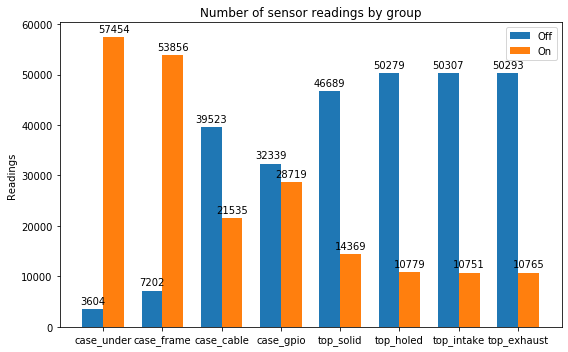

In [6]:
counts = (
    pd.concat([df.groupby(x)["temp"].describe().assign(var = x) for x in dummies])
    .reset_index()
    .rename({"index":"status"},
            axis=1)
    [["var", "status", "count"]]
)

x = np.arange(len(dummies))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize = (8, 5))
rects1 = ax.bar(x - width/2, counts.loc[counts.status == 0]["count"].astype(int), width, label="Off")
rects2 = ax.bar(x + width/2, counts.loc[counts.status == 1]["count"].astype(int), width, label="On")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel("Readings")
ax.set_title("Number of sensor readings by group")
ax.set_xticks(x)
ax.set_xticklabels(dummies)
ax.legend()

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

### Correlation

A correlation matrix displays all pairings of variables and displays their correlation coefficient. A correlation coefficient is a measure of how much two things "move" together. For example, there would be a positive correlation between CPU temperature and CPU usage: CPUs get hot when they work.

In [7]:
# Print the correlation matrix
df.corr()

,usage,temp,stress,load,case_under,case_frame,case_cable,case_gpio,top_solid,top_holed,top_intake,top_exhaust,heatsink_main,heatsink_sub
usage,1.000000,0.211161,0.996410,NaN,0.009602,0.021269,0.015588,0.030559,0.002887,0.002843,0.005869,-0.001782,NaN,NaN
temp,0.211161,1.000000,0.209753,NaN,-0.056786,-0.092558,-0.180056,0.142723,0.477361,0.324209,-0.700335,-0.386083,NaN,NaN
stress,0.996410,0.209753,1.000000,NaN,0.009602,0.021360,0.014061,0.029972,0.001710,0.002703,0.005867,-0.000945,NaN,NaN
load,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
case_under,0.009602,-0.056786,0.009602,NaN,1.000000,0.684893,0.184876,0.236023,0.138944,0.115965,0.115782,0.115874,NaN,NaN
case_frame,0.021269,-0.092558,0.021360,NaN,0.684893,1.000000,0.269934,0.344612,0.202869,0.169319,0.169052,0.169185,NaN,NaN
case_cable,0.015588,-0.180056,0.014061,NaN,0.184876,0.269934,1.000000,0.290143,0.171632,-0.018675,0.303738,-0.019319,NaN,NaN
case_gpio,0.030559,0.142723,0.029972,NaN,0.236023,0.344612,0.290143,1.000000,0.032059,0.182196,-0.126709,0.181651,NaN,NaN
top_solid,0.002887,0.477361,0.001710,NaN,0.138944,0.202869,0.171632,0.032059,1.000000,-0.256863,-0.256458,-0.256661,NaN,NaN
top_holed,0.002843,0.324209,0.002703,NaN,0.115965,0.169319,-0.018675,0.182196,-0.256863,1.000000,-0.214046,-0.214215,NaN,NaN


In [8]:
df.corr()["temp"]

usage            0.211161
temp             1.000000
stress           0.209753
load                  NaN
case_under      -0.056786
case_frame      -0.092558
case_cable      -0.180056
case_gpio        0.142723
top_solid        0.477361
top_holed        0.324209
top_intake      -0.700335
top_exhaust     -0.386083
heatsink_main         NaN
heatsink_sub          NaN
Name: temp, dtype: float64

### Visualizing data

Scatter plots are usually pretty nice to see, but here temperature is our only really continuous variable. Usage tends to cluster around values since our tests operate by cores. So usage clusters around 25, 50, 75, and 100.

Nevertheless, you can see how various case components "split" along temperatures. Notice that the points are always the same between plots: only the color of the dots is changing.

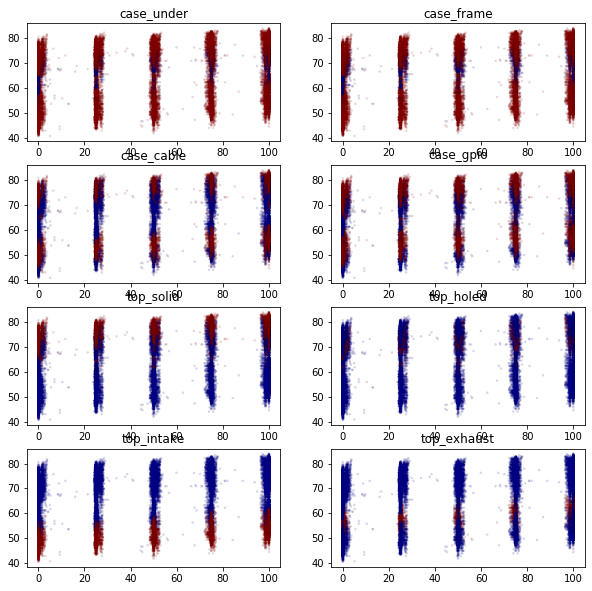

In [9]:
fig, axs = plt.subplots(math.ceil(len(dummies)/2), 2, figsize=(10, 10))
for n, x in enumerate(dummies):
    axs[n//2, n%2].scatter(df.usage, df.temp, s=3, c=df[x], cmap = "jet", alpha=0.1)
    axs[n//2, n%2].set_title(x)
plt.show()

#### Boxplots for a clearer view

There is a much better way of essentially seeing the same information as the scatter plot above. (Later I'll show example of regression line plots, which are a bit nicer scatter plots.)

Box plots visually represent a few summary statistics relating to distribution. The orange line is the median and the box it's in is the 25-75 quantile range. Basically, the box shows you where half of the data resides. The whiskers are the maximum and minimum data points that are not considered outliers, so the whiskers show you the range of the majority of the data.

As you can see, having a solid top case pushes the distribution of temperatures up. Having a fan pushes temperatures down and squishes them together.

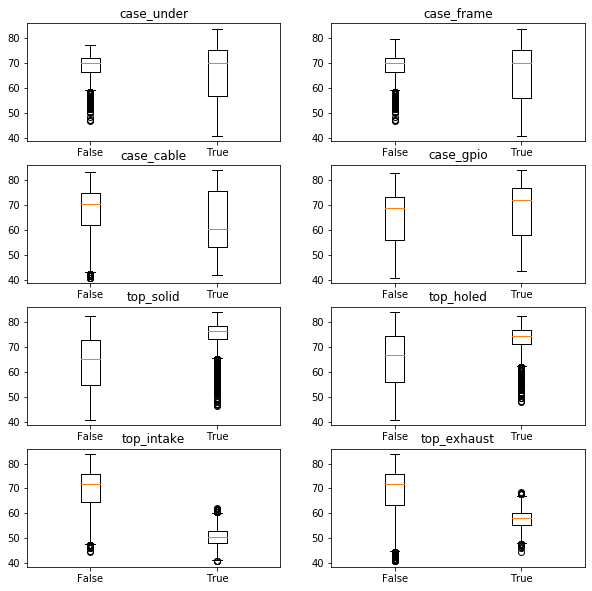

In [10]:
# Boxplots only accept 1D data, but can plot multiple series at a time
fig, axs = plt.subplots(math.ceil(len(dummies)/2), 2, figsize=(10, 10))
for n, x in enumerate(dummies):
    axs[n//2, n%2].boxplot([df.loc[df[x] == 0]["temp"], df.loc[df[x] == 1]["temp"]],
                          labels = ["False", "True"])
    axs[n//2, n%2].set_title(x)
plt.show()

#### Box plot for high-usage only

Here's a more useful thing to plot: box plots of temperatures at maximum usage. This kind of plot will tell us (generally) if temperatures are higher or lower when the CPU is working hard.

Notice that this plot can sometimes be a bit useless. For the bottom case component, there's a lot of range because the bottom case component is often used. More precise statistical techniques have to be used to extract useful information.

Nevertheless, you can still say something like "the median temperature at max usage is 5C higher with the case.

The raspberry pi throttles itself above 60C and heavily throttles above 80C. 

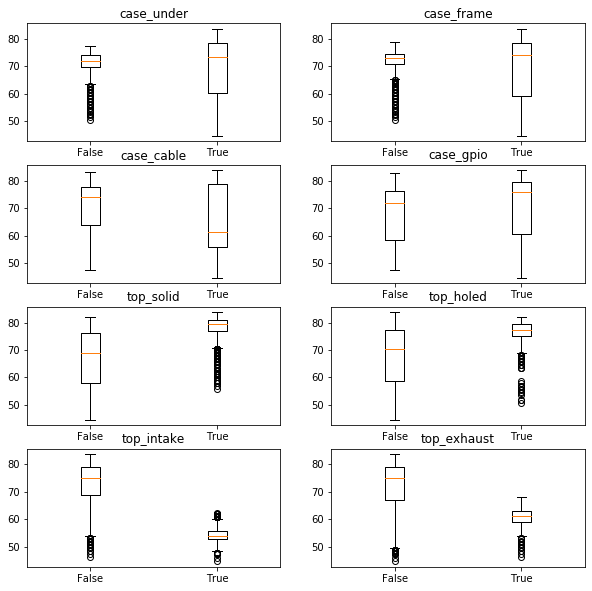

In [11]:
# Boxplots only accept 1D data, but can plot multiple series at a time
fig, axs = plt.subplots(math.ceil(len(dummies)/2), 2, figsize=(10, 10))
max_usage = df.loc[df["usage"] == max(df["usage"])]
for n, x in enumerate(dummies):
    axs[n//2, n%2].boxplot([max_usage.loc[max_usage[x] == 0]["temp"], max_usage.loc[df[x] == 1]["temp"]],
                          labels = ["False", "True"])
    axs[n//2, n%2].set_title(x)
plt.show()

### Comparing case tops

Rather than comparing components one by one, we can pick a few interesting configurations and plot them side-by-side. This way we can see how temperatures differ.

Below we can use the `np.polyfit()` function to add a line to better make sense of the scatter plot. This is linear regression. Given a cloud of points, the line will try to settle at the cloud's center; or it finds the line that is closest to all dots, the line that has the minimum distance to all dots.

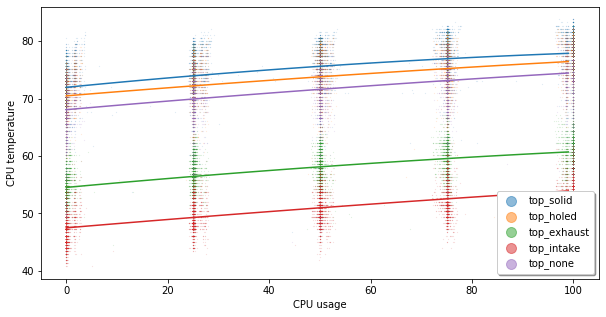

In [16]:
tops = ["top_solid", "top_holed", "top_exhaust", "top_intake", "top_none"]

plt.figure(figsize=(10,5))
for top in tops:
    df_copy = df.copy()
    df_copy = df_copy.loc[df_copy.case_under == 1]
    df_copy = df_copy.loc[df_copy.case_frame == 1]
    if top == "top_none":
        for t in tops:
            if t != "top_none":
                df_copy = df_copy.loc[df_copy[t] == 0]
    else:
        df_copy = df_copy.loc[df_copy[top] == 1]
    # Fitting a 2nd order polynomial curve to the data
    coef = np.polyfit(df_copy.usage, df_copy.temp, 2)
    poly1d_fn = np.poly1d(coef) 
    plt.scatter(df_copy.usage, df_copy.temp, s=0.01, cmap = "jet", alpha=0.5, label=top)
    plt.plot(np.arange(100), poly1d_fn(np.arange(100)))
    plt.xlabel("CPU usage")
    plt.ylabel("CPU temperature")
plt.legend(loc='best', shadow=True, fancybox=True, markerscale=100)
plt.show()

### Looking at time series

Our data is all time-stamped, so we ought to see what that looks like. It's a good idea to do this in order to see if anything is amiss.

In [13]:
df_dt = df

# Convert the datetime column to a datetime dtype
# This works fine since the datetime is already in a standard format
df_dt["datetime"] = pd.to_datetime(df_dt["datetime"])
df_dt["datetime"] = pd.DatetimeIndex(df_dt["datetime"])

df_dt = df_dt.set_index(df_dt["datetime"])

# Round the datetime to the second
df_dt.index = df_dt.index.round("s")

# Drop the old datetime column
df_dt = df_dt.drop("datetime", axis = 1)

In [14]:
all_closed_obs = (
    df_dt
    .loc[lambda df: df.case_under == 1]
    .loc[lambda df: df.case_frame == 1]
    .loc[lambda df: df.case_cable == 1]
    .loc[lambda df: df.case_gpio == 1]
    .loc[lambda df: df.top_solid == 1]
    .loc[lambda df: df.top_holed == 0]
    .loc[lambda df: df.top_intake == 0]
    .loc[lambda df: df.top_exhaust == 0]
)

open_obs = (
    df_dt
    .loc[lambda df: df.case_under == 1]
    .loc[lambda df: df.case_frame == 1]
    .loc[lambda df: df.case_cable == 0]
    .loc[lambda df: df.case_gpio == 0]
    .loc[lambda df: df.top_solid == 0]
    .loc[lambda df: df.top_holed == 0]
    .loc[lambda df: df.top_intake == 0]
    .loc[lambda df: df.top_exhaust == 0]
)

good_fan_obs = (
    df_dt
    .loc[lambda df: df.case_under == 1]
    .loc[lambda df: df.case_frame == 1]
    .loc[lambda df: df.case_cable == 1]
    .loc[lambda df: df.case_gpio == 0]
    .loc[lambda df: df.top_solid == 0]
    .loc[lambda df: df.top_holed == 0]
    .loc[lambda df: df.top_intake == 1]
    .loc[lambda df: df.top_exhaust == 0]
)

It turns out that me might have a problem. Closed cases are able to build up heat and remain at higher temperatures. This may be a good description of what temperatures are like in day-to-day operation, but it's a poor data source for closed-case behaviour at lower temperatures. If we wanted to see how long it takes for a closed case to cool down, we wouldn't have a good idea with this data.

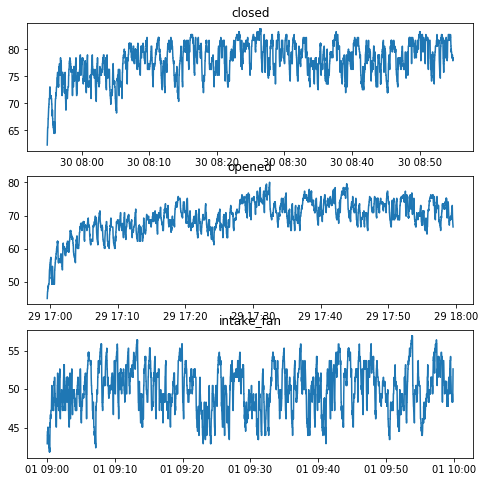

In [15]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8))
axs[0].plot(all_closed_obs.index, all_closed_obs.temp)
axs[0].set_title("closed")
axs[1].plot(open_obs.index, open_obs.temp)
axs[1].set_title("opened")
axs[2].plot(good_fan_obs.index, good_fan_obs.temp)
axs[2].set_title("intake_fan")
plt.show()